In [1]:
import random
import numpy as np
import pandas as pd
import time
import re
import datetime
import os
import matplotlib.pyplot as plt
import gensim

In [ ]:
# pip install gensim

In [ ]:
import spacy

In [2]:
from gensim.test.utils import common_texts
from gensim.utils import tokenize
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.models import TfidfModel
from gensim.models import CoherenceModel

In [3]:
sent = '''Russian Foreign Minister Sergey Lavrov discussed the Geneva and Brussels meetings on guarantees of security during a phone call with his Greek counterpart Nikos Dendias on Wednesday, the Russian Foreign Ministry said in a statement.'''

In [4]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

NameError: name 'spacy' is not defined

In [203]:
def customTokenize(doc):
    return [t.lemma_.lower() for t in doc if ((t.pos_ in ['NOUN','ADJ','PROPN']) and (t.text not in nlp.Defaults.stop_words))]

def preprocess_pipe(texts):
    preproc_pipe = []
    ct = 0
    for doc in nlp.pipe(texts, batch_size=20):
        if ct % 100 == 0:
            print(f'{ct}/{len(texts)} texts processed by Spacy.')
        preproc_pipe.append(customTokenize(doc))
        ct += 1
    print(f'{len(texts)}/{len(texts)} texts processed by Spacy.')
    return preproc_pipe

preprocess_pipe([sent])

0/1 texts processed by Spacy.
1/1 texts processed by Spacy.


[['russian',
  'foreign',
  'minister',
  'sergey',
  'lavrov',
  'geneva',
  'brussels',
  'meeting',
  'guarantee',
  'security',
  'phone',
  'greek',
  'counterpart',
  'nikos',
  'dendias',
  'wednesday',
  'russian',
  'foreign',
  'ministry',
  'statement']]

In [204]:
# tokenize text and create corpus
start = time.time()
texts = []
for outlet in dfDict:
    for i, text in enumerate(dfDict[outlet]['text']):
        if isinstance(text, str):
            texts.append(text)
            
tokenized_texts = list(preprocess_pipe(texts))
middle = time.time()
print(f'docs processed successfully in {middle - start}s.')

dictionary = Dictionary(tokenized_texts)

bow_corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
model = TfidfModel(bow_corpus)

tfidf_docs = [model[doc] for doc in bow_corpus]
end = time.time()
print(f'completed in {end-start}s.')

0/2615 texts processed by Spacy.
100/2615 texts processed by Spacy.
200/2615 texts processed by Spacy.
300/2615 texts processed by Spacy.
400/2615 texts processed by Spacy.
500/2615 texts processed by Spacy.
600/2615 texts processed by Spacy.
700/2615 texts processed by Spacy.
800/2615 texts processed by Spacy.
900/2615 texts processed by Spacy.
1000/2615 texts processed by Spacy.
1100/2615 texts processed by Spacy.
1200/2615 texts processed by Spacy.
1300/2615 texts processed by Spacy.
1400/2615 texts processed by Spacy.
1500/2615 texts processed by Spacy.
1600/2615 texts processed by Spacy.
1700/2615 texts processed by Spacy.
1800/2615 texts processed by Spacy.
1900/2615 texts processed by Spacy.
2000/2615 texts processed by Spacy.
2100/2615 texts processed by Spacy.
2200/2615 texts processed by Spacy.
2300/2615 texts processed by Spacy.
2400/2615 texts processed by Spacy.
2500/2615 texts processed by Spacy.
2600/2615 texts processed by Spacy.
2615/2615 texts processed by Spacy.
docs

In [205]:
### RUN LDA MODEL
n = 12
lda = LdaModel(tfidf_docs, num_topics=n, id2word=dictionary, passes=10)

In [197]:
# run coherence test
coherences = []
for n in range(1,50):
    print('Num_topics:', n)
    lda = LdaModel(tfidf_docs, num_topics=n, id2word=dictionary, passes=10)
    coherence_score_lda = CoherenceModel(model=lda, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_score_lda.get_coherence()
    print('\tCoherence Score:', coherence_score)
    coherences.append((n,coherence_score))

Num_topics: 1
	Coherence Score: 0.40713286945829885
Num_topics: 2
	Coherence Score: 0.3175497868299936
Num_topics: 3
	Coherence Score: 0.45973383000043283
Num_topics: 4
	Coherence Score: 0.5064685049603899
Num_topics: 5
	Coherence Score: 0.5008246052694678
Num_topics: 6
	Coherence Score: 0.44842460325127426
Num_topics: 7
	Coherence Score: 0.4303979681615267
Num_topics: 8
	Coherence Score: 0.5290163637409008
Num_topics: 9
	Coherence Score: 0.4816387523410458
Num_topics: 10
	Coherence Score: 0.5277803594140493
Num_topics: 11
	Coherence Score: 0.5399137101379126
Num_topics: 12
	Coherence Score: 0.5908341269143892
Num_topics: 13
	Coherence Score: 0.5736227665289233
Num_topics: 14
	Coherence Score: 0.5306048513639268
Num_topics: 15
	Coherence Score: 0.5107157689216794
Num_topics: 16
	Coherence Score: 0.5414645740085369
Num_topics: 17
	Coherence Score: 0.5343388034448232
Num_topics: 18
	Coherence Score: 0.5328256314006701
Num_topics: 19
	Coherence Score: 0.5528933407519497
Num_topics: 20
	Co

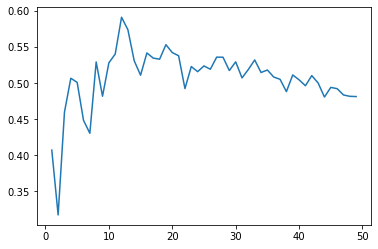

In [198]:
plt.plot([p[0] for p in coherences],[p[1] for p in coherences])
plt.show()

In [199]:
max_c = 0
max_n = 0
for n, c in coherences:
    if c > max_c:
        max_c = c
        max_n = n
print(max_n, max_c)

12 0.5908341269143892


In [189]:
# run perplexity test
%%time
perplexities = []
for n in range(1,50):
    print('Num_topics:', n)
    lda = LdaModel(tfidf_docs, num_topics=n, id2word=dictionary, passes=10)
    perplexity = lda.log_perplexity(tfidf_docs)
    print('\tPerplexity:', perplexity)
    perplexities.append((n,perplexity))

Num_topics: 1
	Perplexity: -9.521011703339461
Num_topics: 2
	Perplexity: -9.708974886870806
Num_topics: 3
	Perplexity: -9.931628209224712
Num_topics: 4
	Perplexity: -9.984254661897982
Num_topics: 5
	Perplexity: -10.127315880934846
Num_topics: 6
	Perplexity: -10.224369307678256
Num_topics: 7
	Perplexity: -10.415322809206307
Num_topics: 8
	Perplexity: -10.52973752820481
Num_topics: 9
	Perplexity: -10.819255231541607
Num_topics: 10
	Perplexity: -11.143517011295668
Num_topics: 11
	Perplexity: -11.569674709486723
Num_topics: 12
	Perplexity: -11.903499956427174
Num_topics: 13
	Perplexity: -12.196172744478451
Num_topics: 14
	Perplexity: -12.429856914198316
Num_topics: 15
	Perplexity: -12.800939725382523
Num_topics: 16
	Perplexity: -13.073610231278344
Num_topics: 17
	Perplexity: -13.385786766704879
Num_topics: 18
	Perplexity: -13.866945973103668
Num_topics: 19
	Perplexity: -14.057219187680557
Num_topics: 20
	Perplexity: -14.353491502927582
Num_topics: 21
	Perplexity: -14.7874785480847
Num_topi

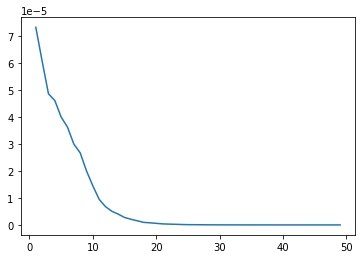

CPU times: user 183 ms, sys: 107 ms, total: 290 ms
Wall time: 904 ms


In [196]:
%%time
plt.plot([p[0] for p in perplexities],[math.e**p[1] for p in perplexities])
plt.show()

In [214]:
topicKeywords = dict()
for topic, wordProbStr in lda.show_topics(num_topics=15):
    keyStr = ''
    for wordStr in [w.strip() for w in wordProbStr.split('+')]:
        prob = wordStr.split('*')[0]
        wordID = wordStr.split('*')[1].replace('"','')
        # token = dictionary[int(wordID)]
        # keyStr = keyStr + f'+{prob}*{wordID}'
        keyStr = keyStr + ' ' + wordID
    topicKeywords[topic] = keyStr
    print(topic, keyStr)

0  eurovision contest song steelwork kalush orchestra band parade ebu turin
1  oksana navalny corbyn medvedchuk borough sheeran topolya emma antytila remnant
2  bush lysychansk coventry bowen dr. sibley ghost archer slovyansk birth
3  iaea pet chernobyl grossi reactor monastery energoatom lgbt radiation exclusion
4  javid gould conscription ecclestone chicken sajid endeavour statue mi-24 questionnaire
5  simmons fabrication okonjo iweala forecast urdd burak oecd melinda grandchild
6  mr uk city nato war bbc putin kyiv us zelensky
7  kateryna venediktova sasha hacker orthodox nebenzia fossil georgieva malpass ballet
8  cup play hampden stadium ambulance player art uefa szmidt mykolaiv
9  israel jewish holocaust jews bennett israeli epic fortnite slovenian xbox
10  lysychansk orban serhiy von leyen der gazprom app cup embargo
11  wales welsh sponsor cardiff moskva easter sponsorship renault evil housing


In [215]:
#Create a dictionary, with topic ID as the key, and the value is a list of tuples (docID, probability of this particular topic for the doc) 

topic_dict = {i: [] for i in range(lda.num_topics)}  # Assuming you have 20 topics. 

#Loop over all the documents to group the probability of each topic
for docID in range(len(tfidf_docs)):
    topic_vector = lda[tfidf_docs[docID]]
    for topicID, prob in topic_vector:
        topic_dict[topicID].append((docID, prob))

#Then, you can sort the dictionary to find the top 20 documents
for topicID, probs in topic_dict.items():
    print(topicKeywords[topicID].replace('+',' + ').replace('*',' * '))
    doc_probs = sorted(probs, key = lambda x: x[1], reverse = True)
    docs_top_20 = [dp[0] for dp in doc_probs[:20]]
    print(texts[docs_top_20[0]])
    print()

 eurovision contest song steelwork kalush orchestra band parade ebu turin
MOSCOW (Sputnik) - The Ukrainian band Kalush Orchestra with their song " Stefania" won the Eurovision Song Contest 2022, official voting results read. According to final voting results, Ukraine got 631 points. The United Kingdom, represented by Sam Ryder, came second with 466 points, while Spain, represented by Chanel, finished third with 459 points. The European Broadcasting Union (EBU) announced on February 25 that Russia will not participate in the Eurovision Song Contest in 2022 due to Moscow's military operation in Ukraine. Eurovision 2022 was held in the Italian city of Turin on May 10-14.

 oksana navalny corbyn medvedchuk borough sheeran topolya emma antytila remnant
A Ukrainian band turned soldiers have received a message of support from musician Ed Sheeran. Sheeran is performing at a benefit concert for Ukraine in Birmingham next week, and band Antytila reached out to him via TikTok while dressed in com